In [2]:
import os
import re
import matplotlib.pyplot as plt
import numpy as np

def load_data(dir: str, name: str):
    pattern = re.compile(f"{name}_\d\.csv")

    data = []
    for file in os.listdir(dir):
        if re.match(pattern, file):
            file_name = os.path.join(dir, file)
            line = np.genfromtxt(file_name, skip_header=True, delimiter=',')
            data.append(line)
    data = np.asarray(data)
    
    n = data[0, :,0]
    time = data[:, :, 1]
    return n, time

def mae(actual, predicted):
    actual, predicted = np.asarray(actual), np.asarray(predicted)
    return np.mean(np.abs(actual - predicted))

def n_formatter(x, pos):
    if x < 10**3:
        return f'{x:.0f}'
    if x < 10**6:
        return f'{x/10**3:.1f}K'
    if x < 10**9:
        return f'{x/10**6:.1f}M'
    return f'{x/10**9:.1f}B'

def config_axes(n, y, ax: plt.Axes):
    ax.autoscale(False)

    n_min, n_max = n[0], n[-1]
    ax.set_xticks(np.linspace(n_min, n_max, 9))
    ax.set_xticks(np.linspace(n_min, n_max, 25), minor=True)
    ax.xaxis.set_major_formatter(n_formatter)

    y_min, y_max = y[0], y[-1]
    ax.set_yticks(np.linspace(y_min, y_max, 9))
    ax.set_yticks(np.linspace(y_min, y_max, 25), minor=True)
    
    ax.grid(which='major', alpha=0.5)
    ax.grid(which='minor', alpha=0.2)

def plot_std_area(n, mean, std, ax: plt.Axes):
    y1 = np.asarray(mean)-np.asarray(std)
    y2 = np.asarray(mean)+np.asarray(std)
    ax.fill_between(n, y1, y2, alpha=0.3, label='$\sigma_R$')

def plot_mean(n, mean, ax: plt.Axes):
    ax.plot(n, mean, label=f'$\overline{{R}}$', color='magenta')

def plot_repeats(n, t_reps, ax: plt.Axes):
    for i, v in enumerate(t_reps):
        ax.plot(n, v, label=f'$R_{i+1}$', linestyle=':', linewidth=0.7)

def plot_ideal(n, t, ax: plt.Axes):
    ax.plot(n, t, label='Ideal', linewidth=0.8, color='black')

def plot_statistics_text(mae, std, ax: plt.Axes):
    stats = (f'MAE = {mae:.4f}\n'
             f'$\overline{{\sigma_R}} = {std:.4f}$')
    ax.text(0.84, 0.01, stats, ha='left', va='bottom', transform=ax.transAxes)

def run_O(lang, type, ideal, n, t_reps):
    fig = plt.figure(figsize=(10, 10), dpi=200)

    nt_reps = t_reps[:] / np.max(t_reps[:])
    nmean, nstd = np.mean(nt_reps, axis=0), np.std(nt_reps, axis=0)
    nmae = mae(nmean, ideal(n)[1])

    ax = fig.add_subplot(111)

    ax.set_title(f'{lang}, {type}')
    ax.set_xlabel("$n$")
    ax.set_ylabel("$t^\prime$")
    config_axes(n, [0, 1], ax)
    plot_repeats(n, nt_reps, ax)
    plot_mean(n, nmean, ax)
    plot_std_area(n, nmean, nstd, ax)
    plot_ideal(*ideal(n), ax)
    plot_statistics_text(nmae, np.mean(nstd), ax)
    ax.legend()

    return fig

def ideal_On(n):
    return n, np.linspace(0, 1, len(n))

def ideal_Ologn(n):
    v = np.log(n)
    return n, v / np.max(v)

def ideal_On2(n):
    v = np.square(n)
    return n, v / np.max(v)

def ideal_Onlogn(n):
    v = n * np.log(n)
    return n, v / np.max(v)

def run_On(lang: str, n, t_reps):
    return run_O(lang, "O($n$)", ideal_On, n, t_reps)

def run_Ologn(lang: str, n, t_reps):
    return run_O(lang, "O(log $n$)", ideal_Ologn, n, t_reps)

def run_Onlogn(lang: str, n, t_reps):
    return run_O(lang, "O($n$ log $n$)", ideal_Onlogn, n, t_reps)

def run_On2(lang: str, n, t_reps):
    return run_O(lang, "O($n^2$)", ideal_On2, n, t_reps)

# Go

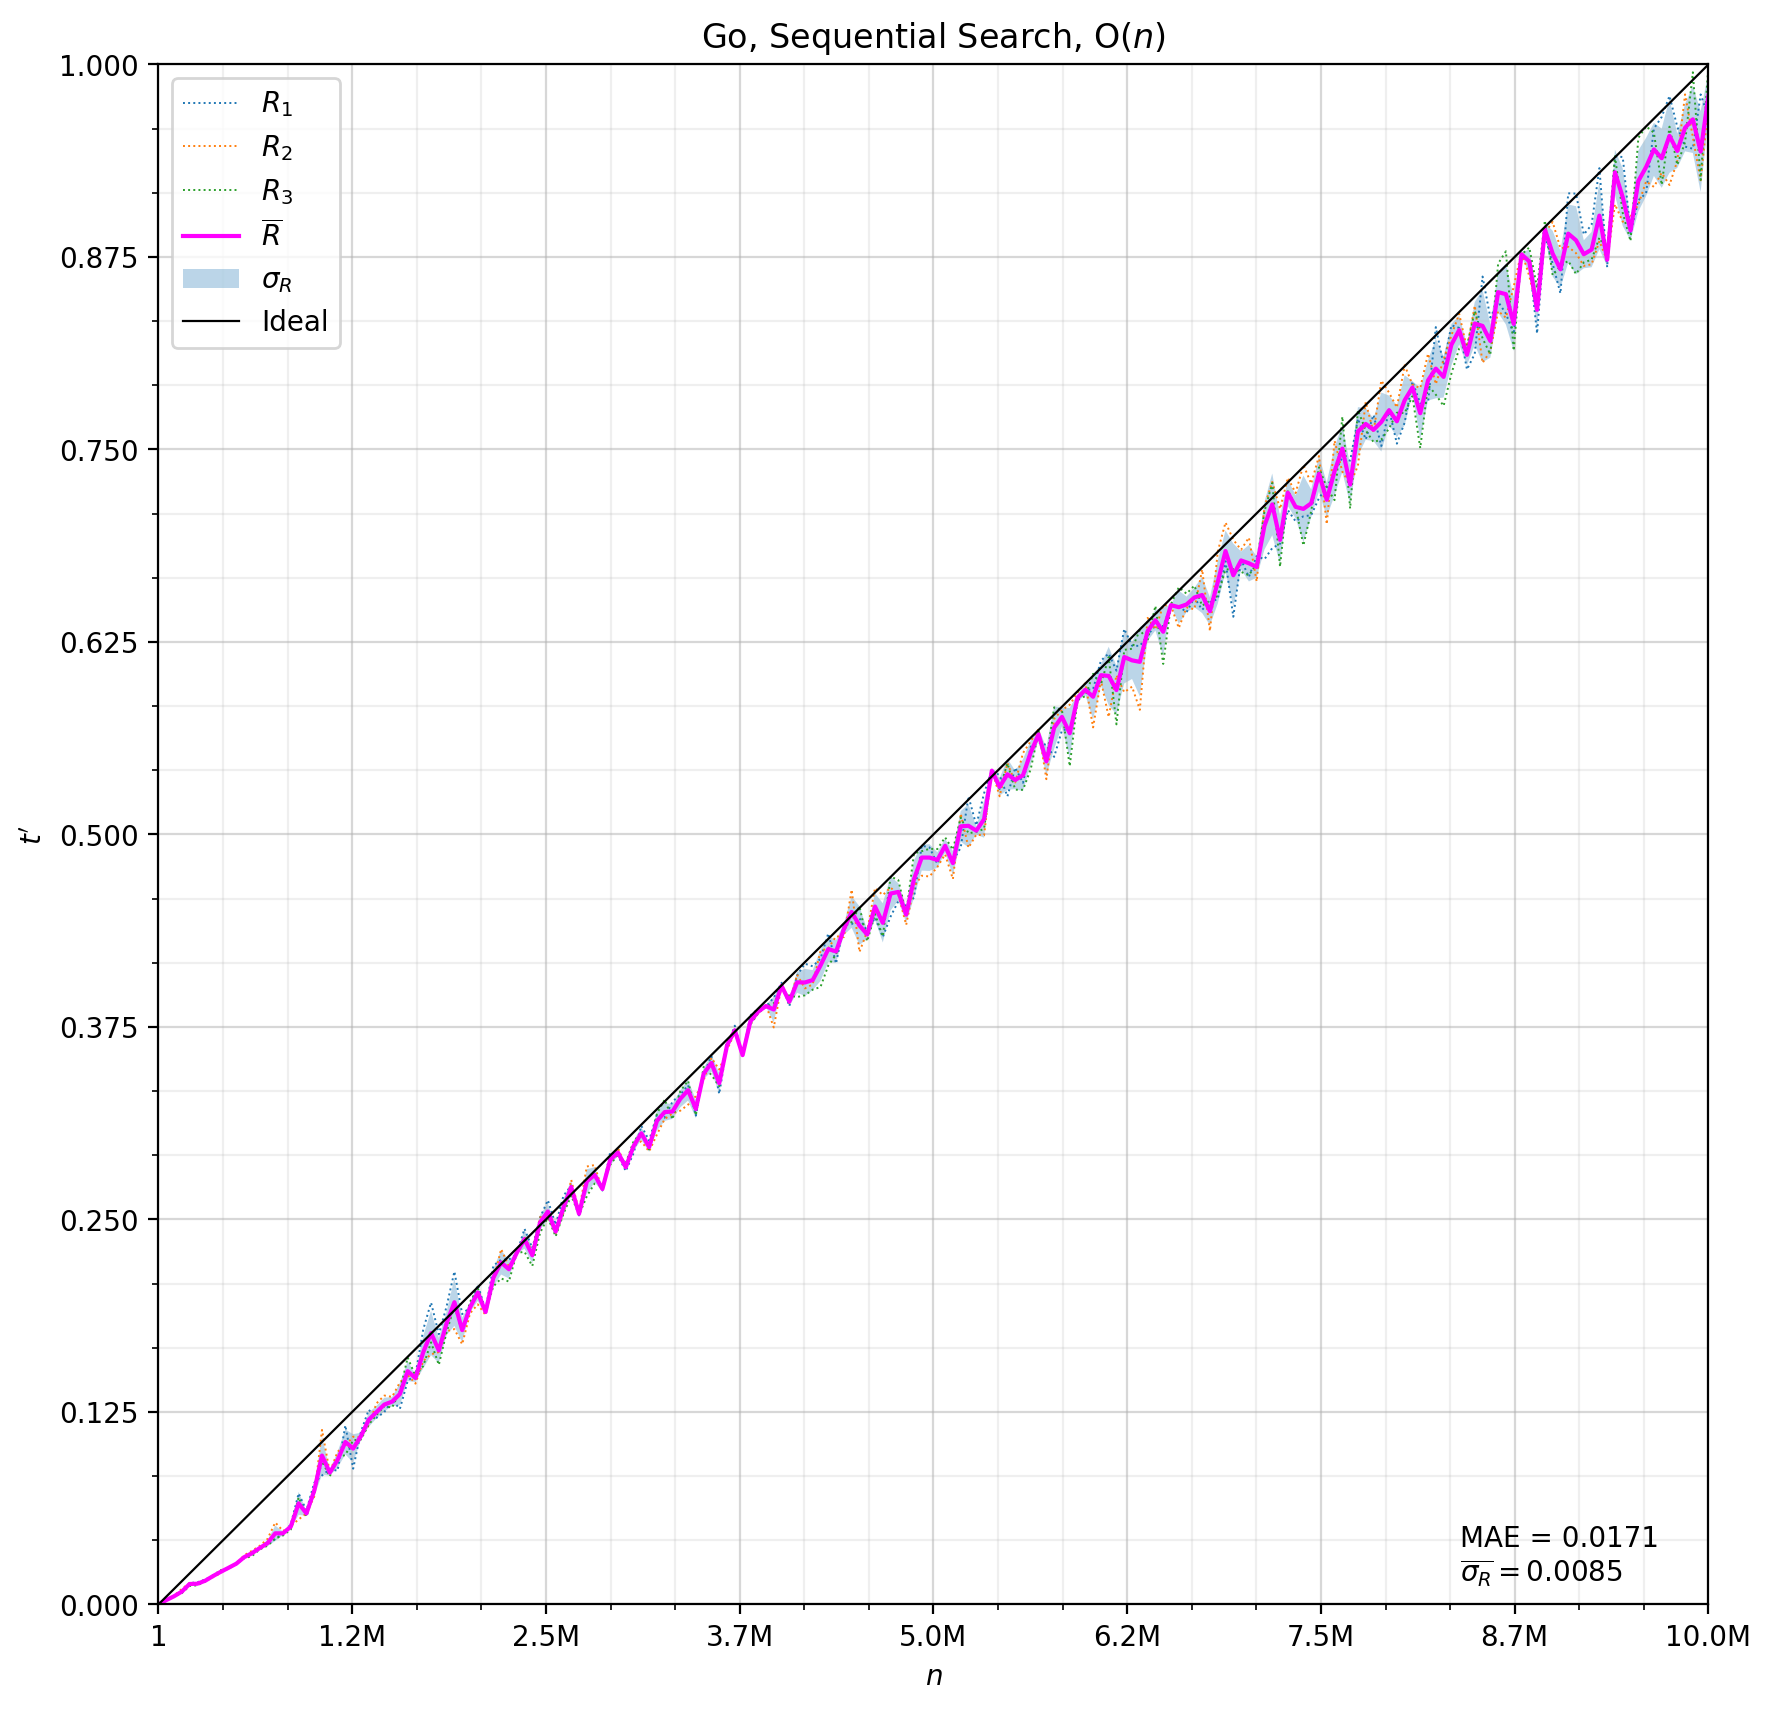

In [3]:
run_On("Go, Sequential Search", *load_data("go/gen/data", "seq_search"));

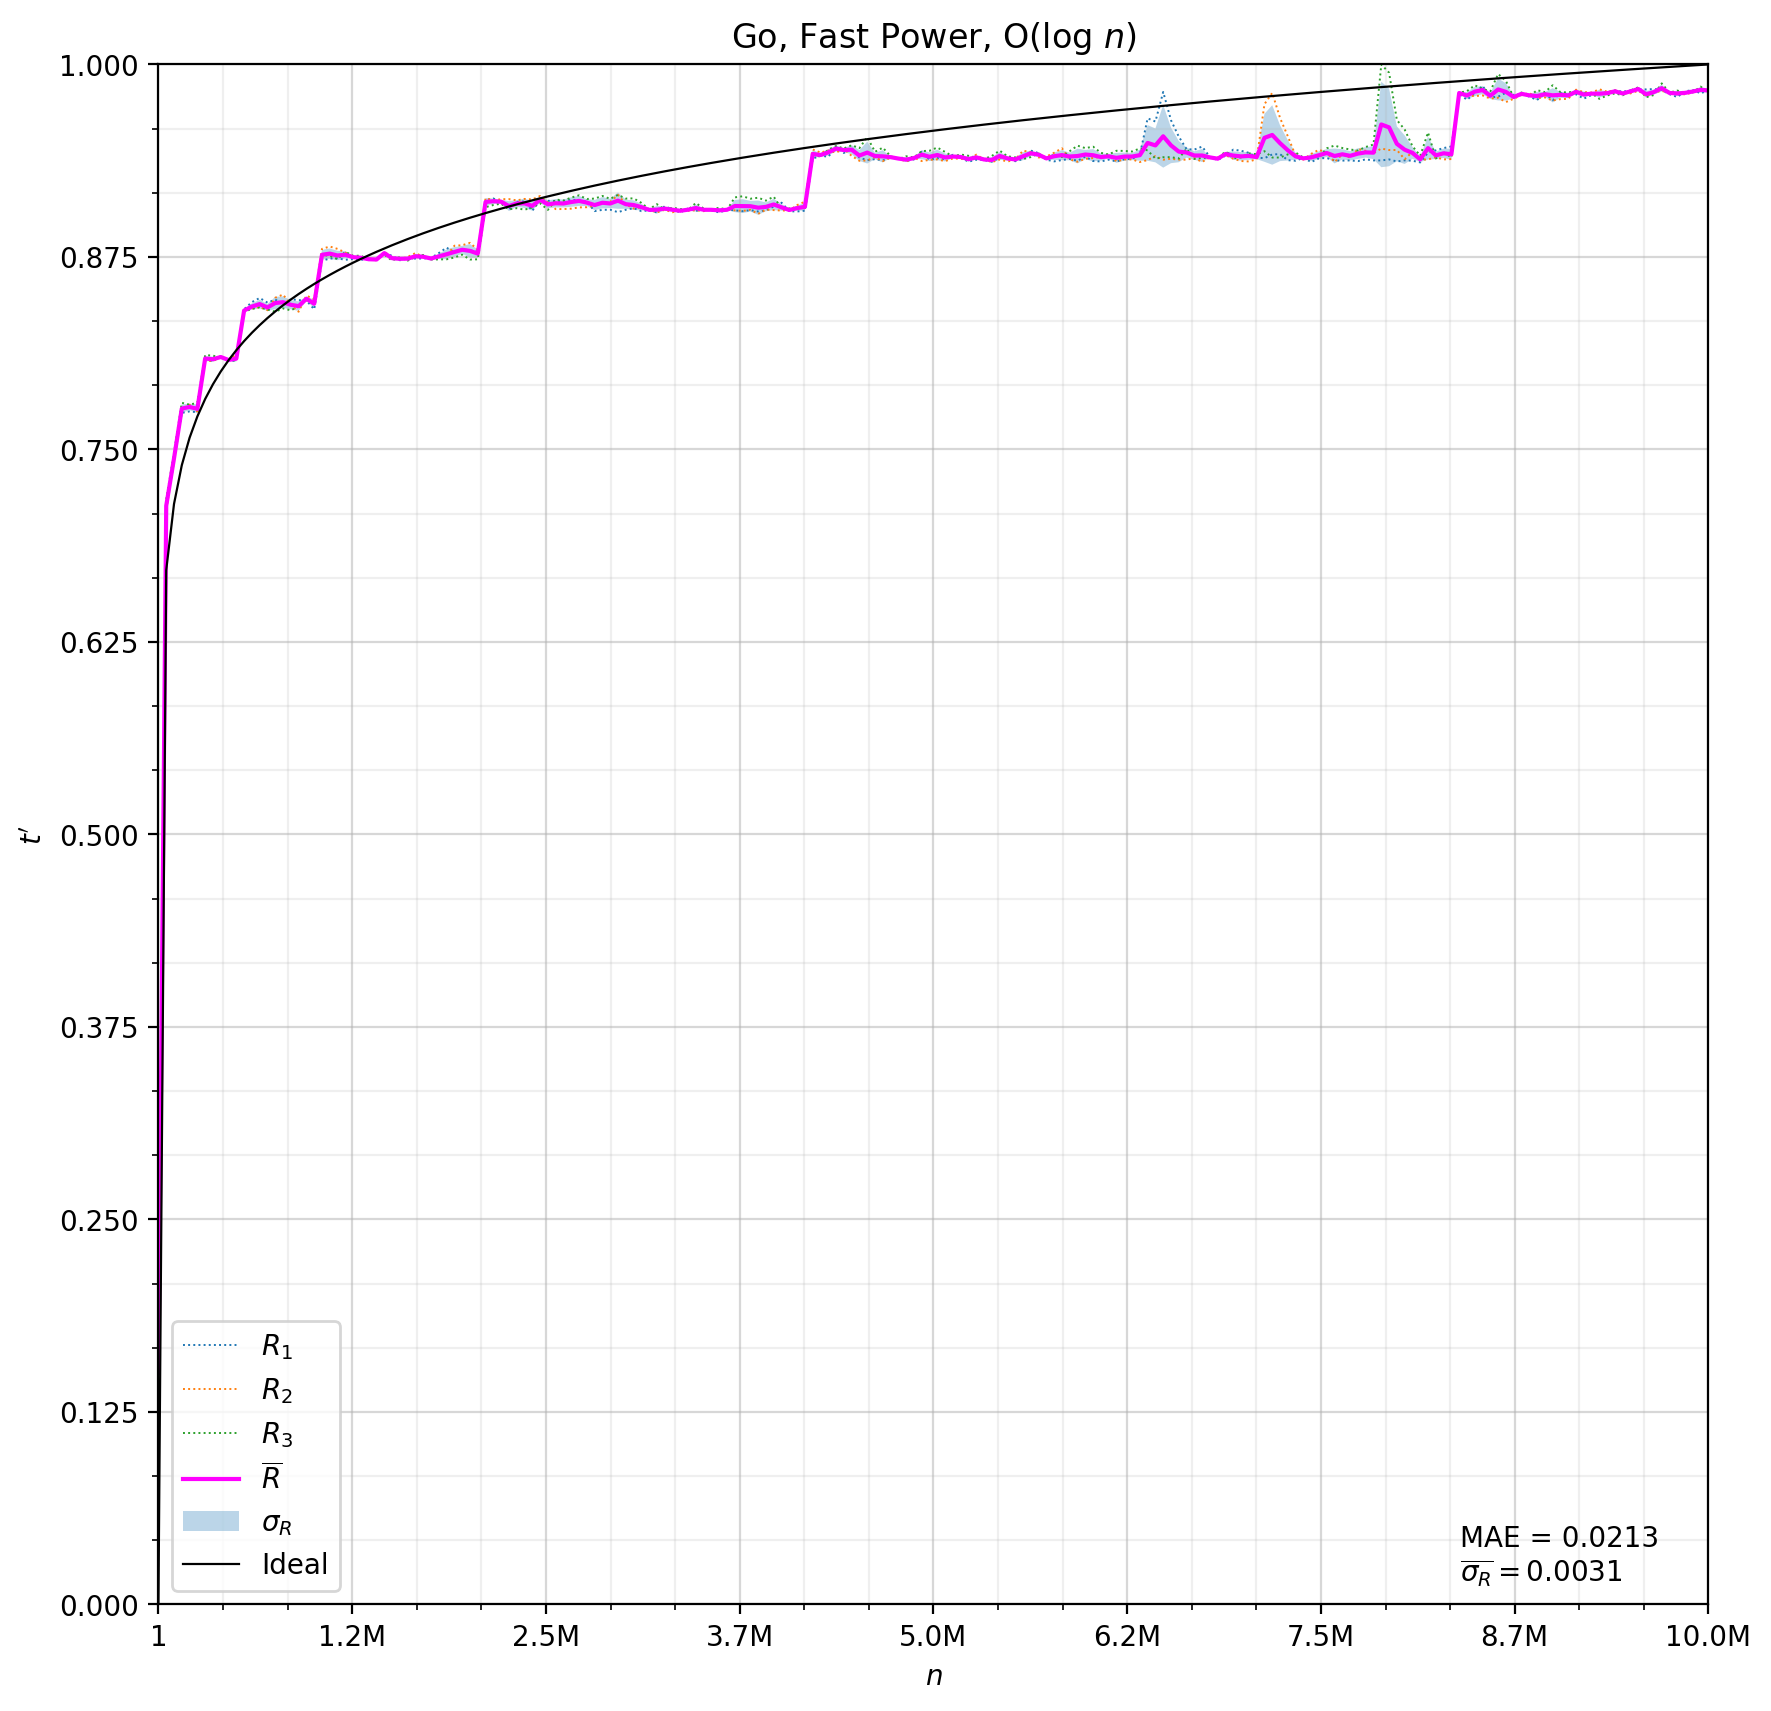

In [4]:
run_Ologn("Go, Fast Power", *load_data("go/gen/data", "fast_power"));

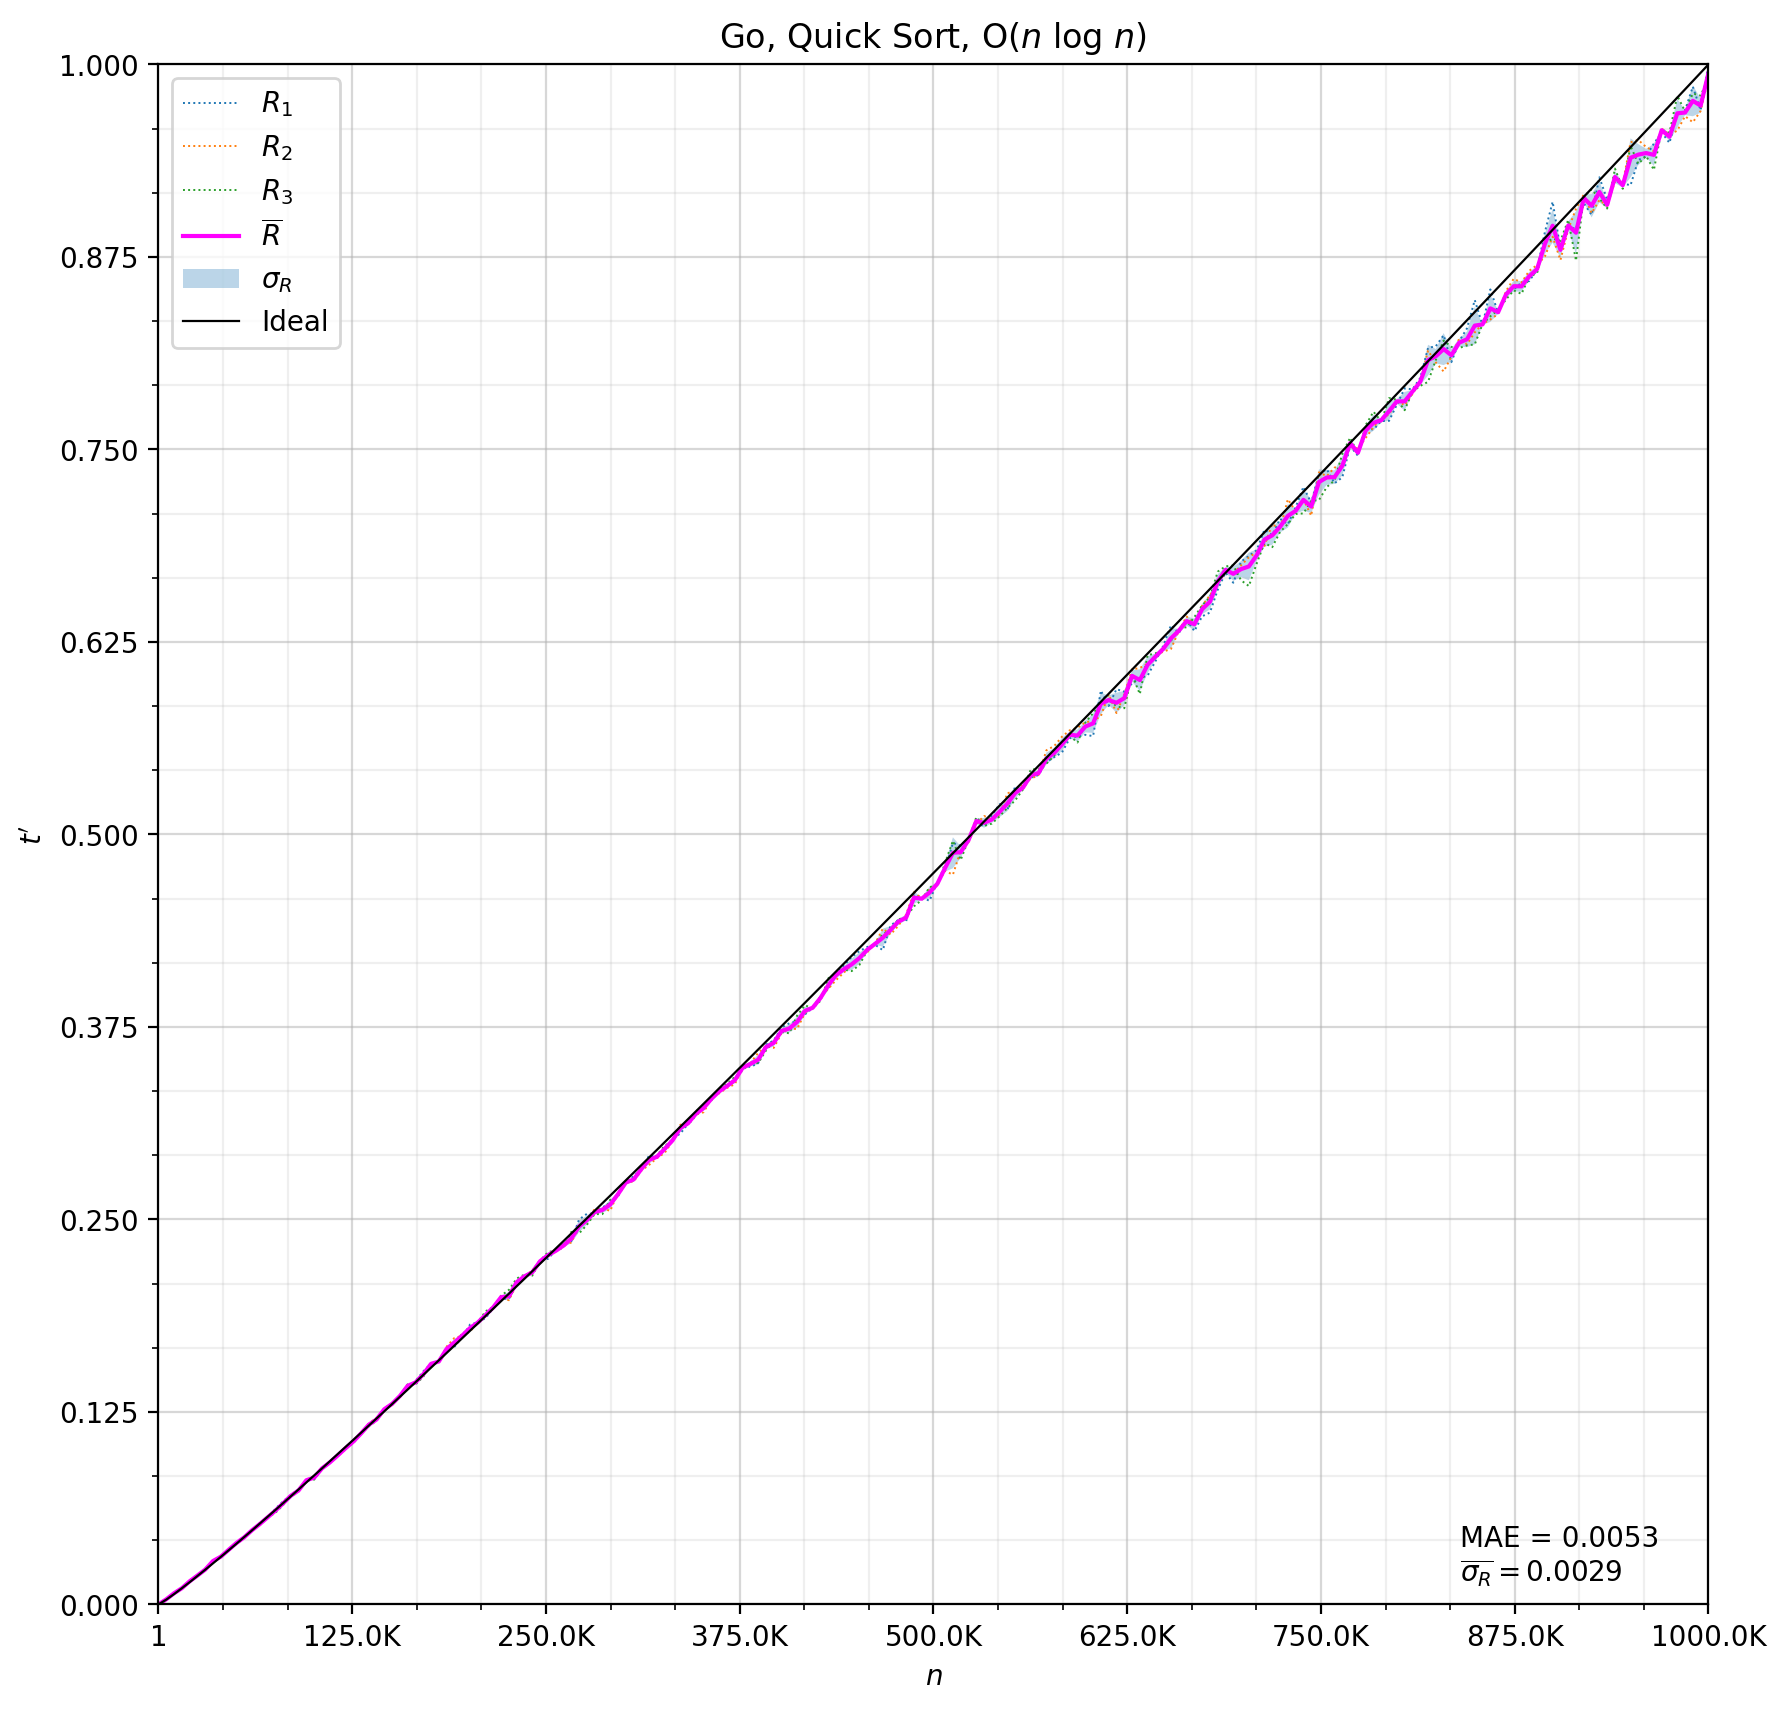

In [5]:
run_Onlogn("Go, Quick Sort", *load_data("go/gen/data", "qsort"));

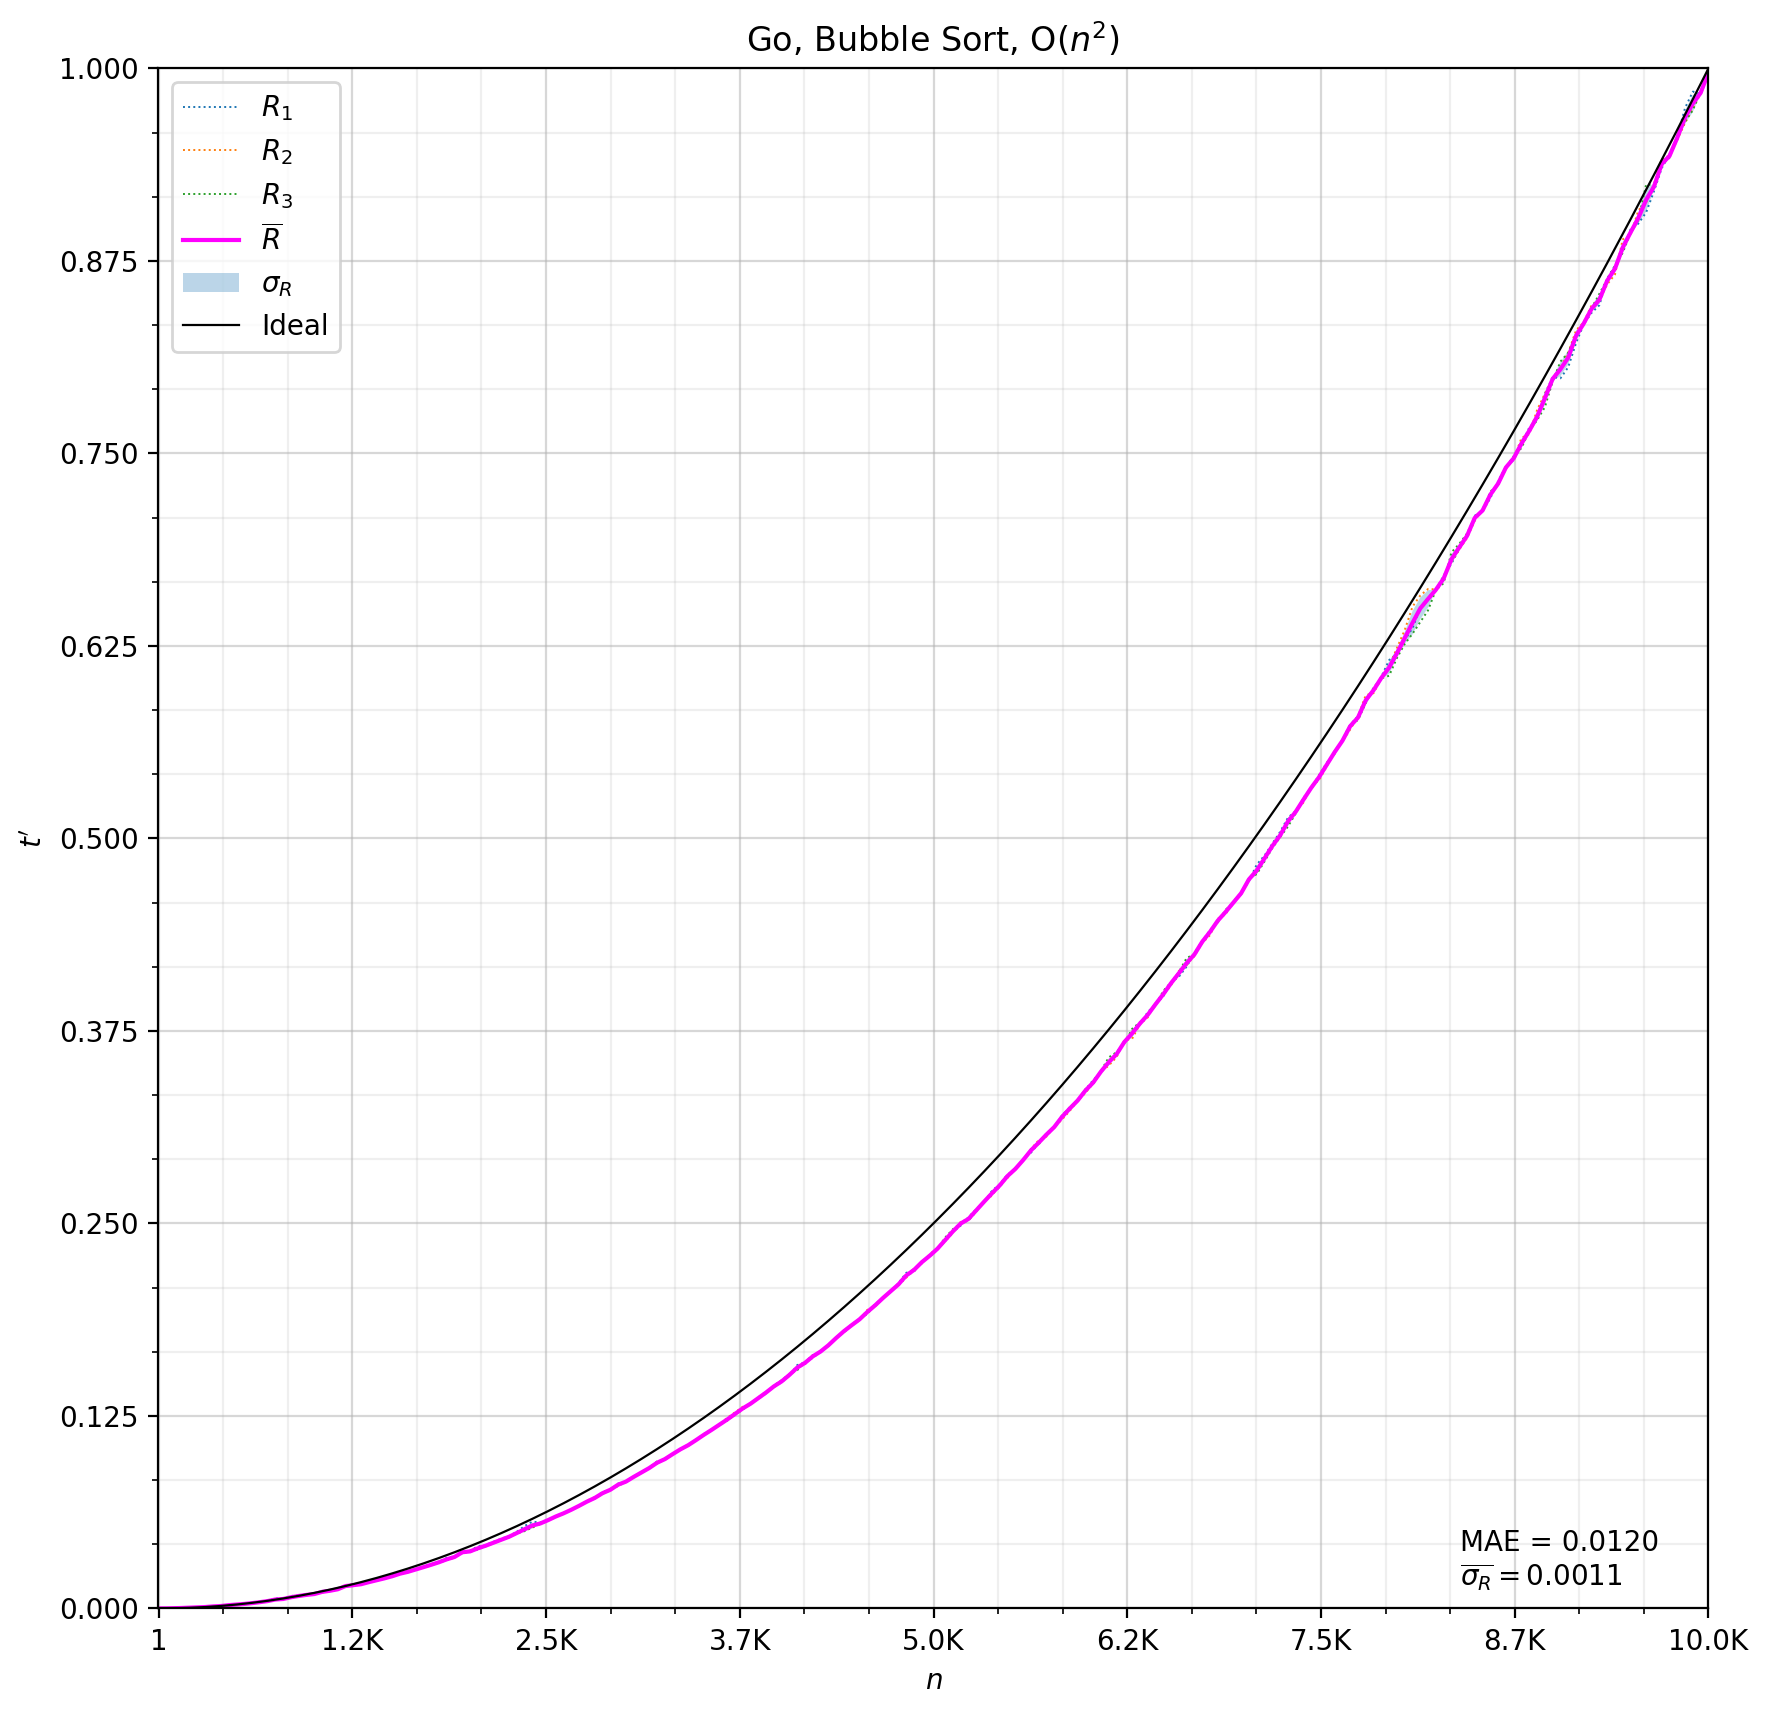

In [6]:
run_On2("Go, Bubble Sort", *load_data("go/gen/data", "bubble_sort"));

# Rust

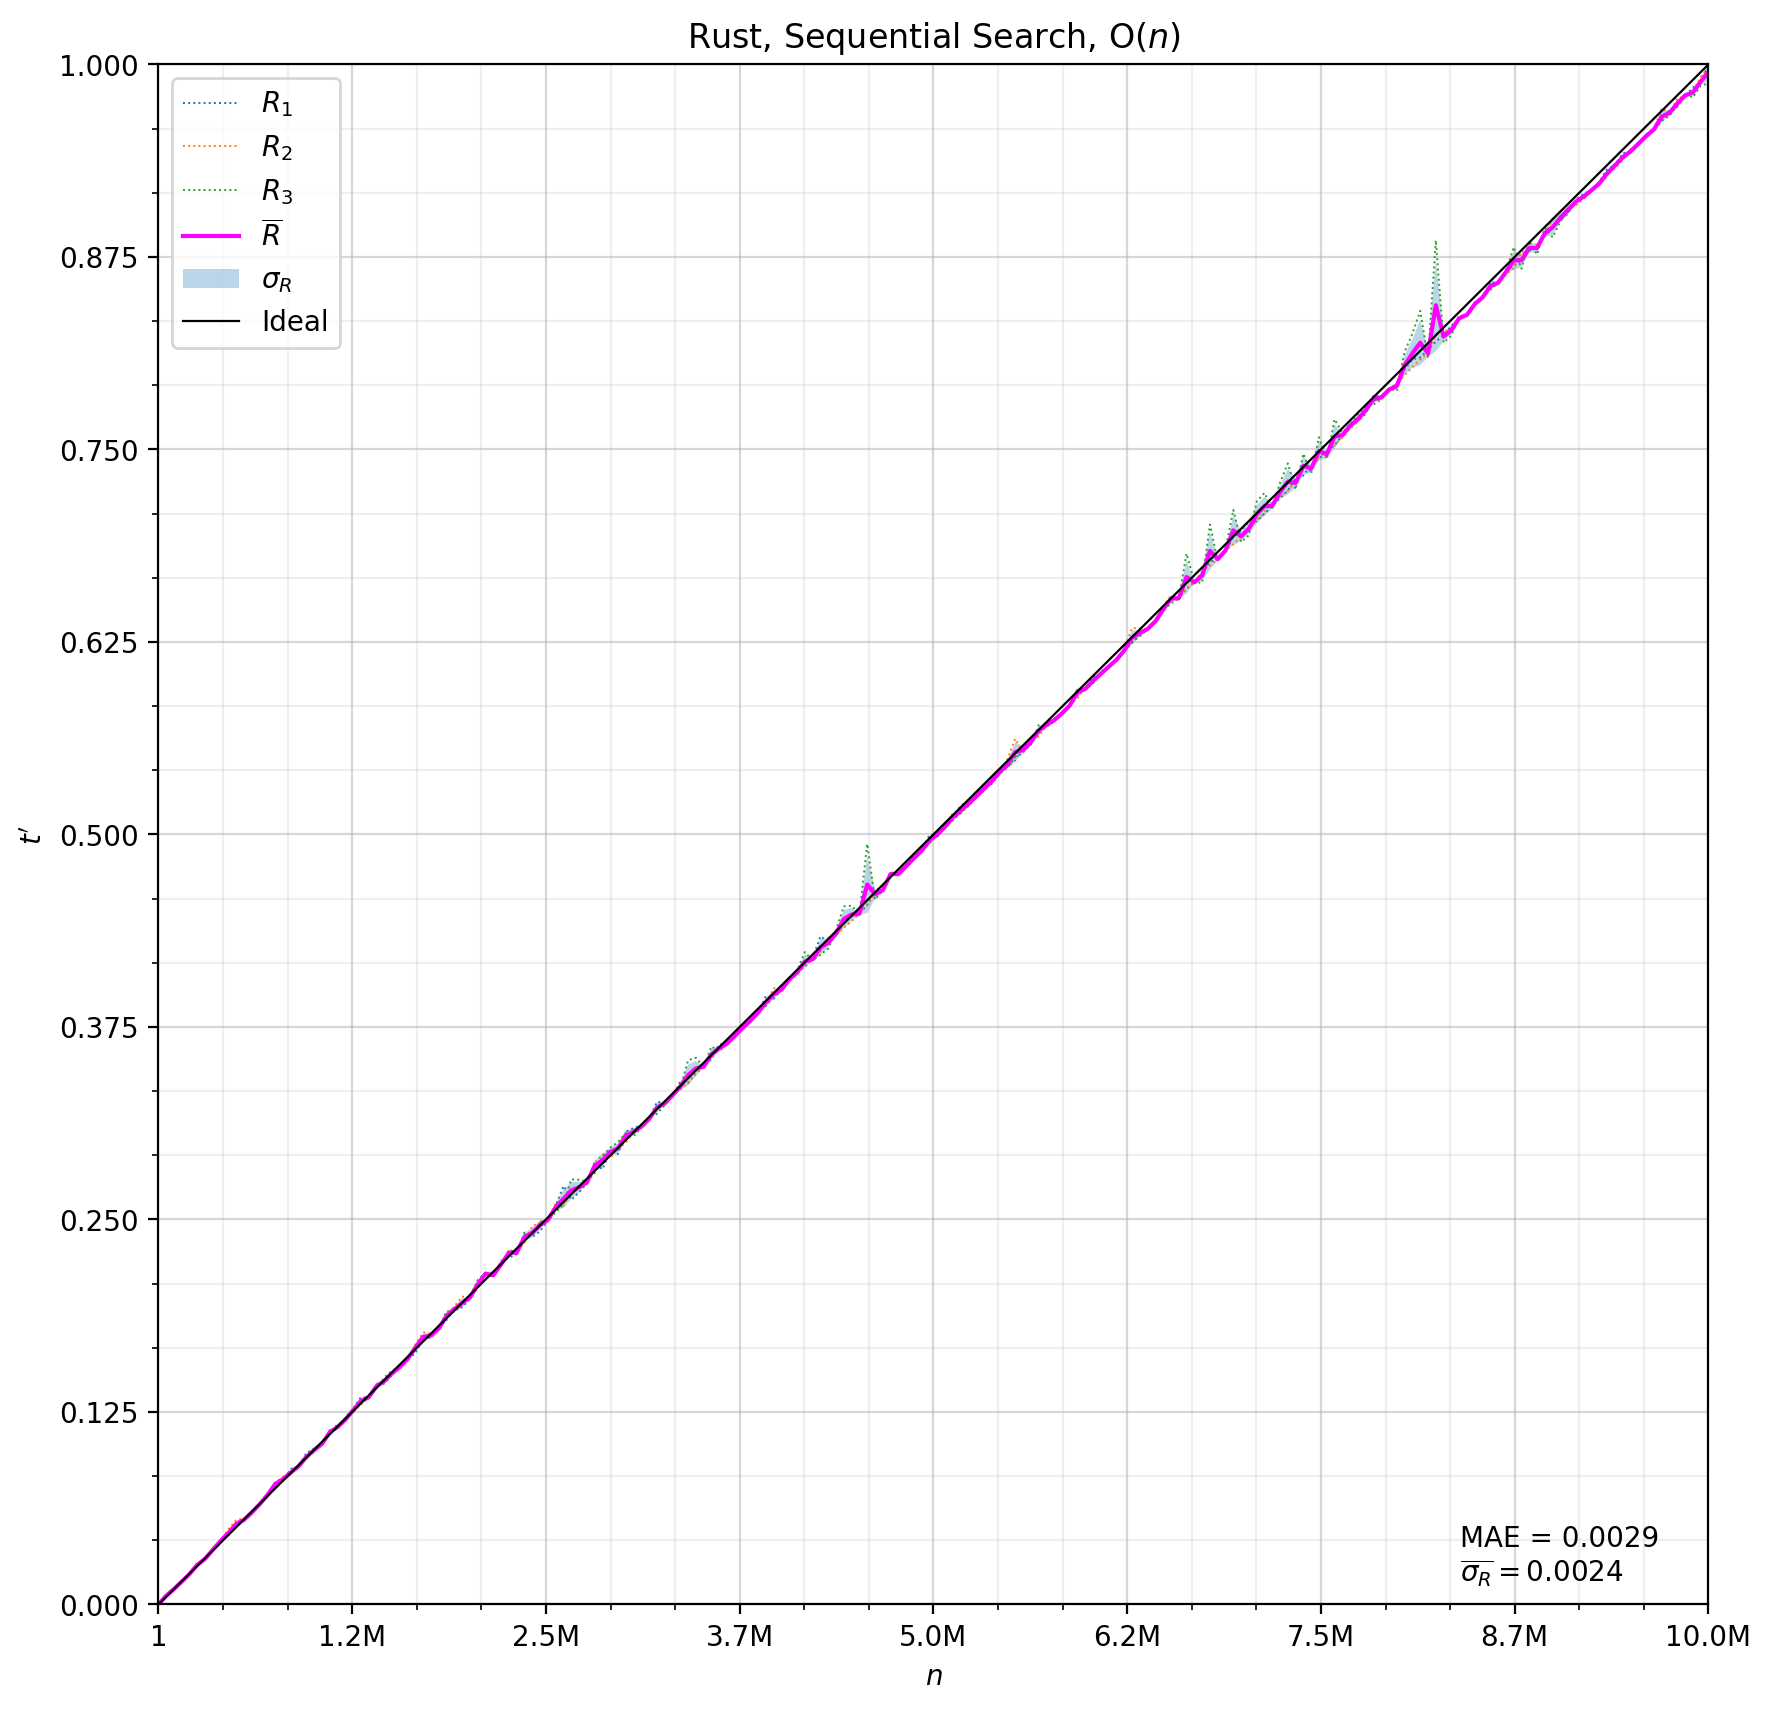

In [7]:
run_On("Rust, Sequential Search", *load_data("rust/gen/data", "seq_search"));

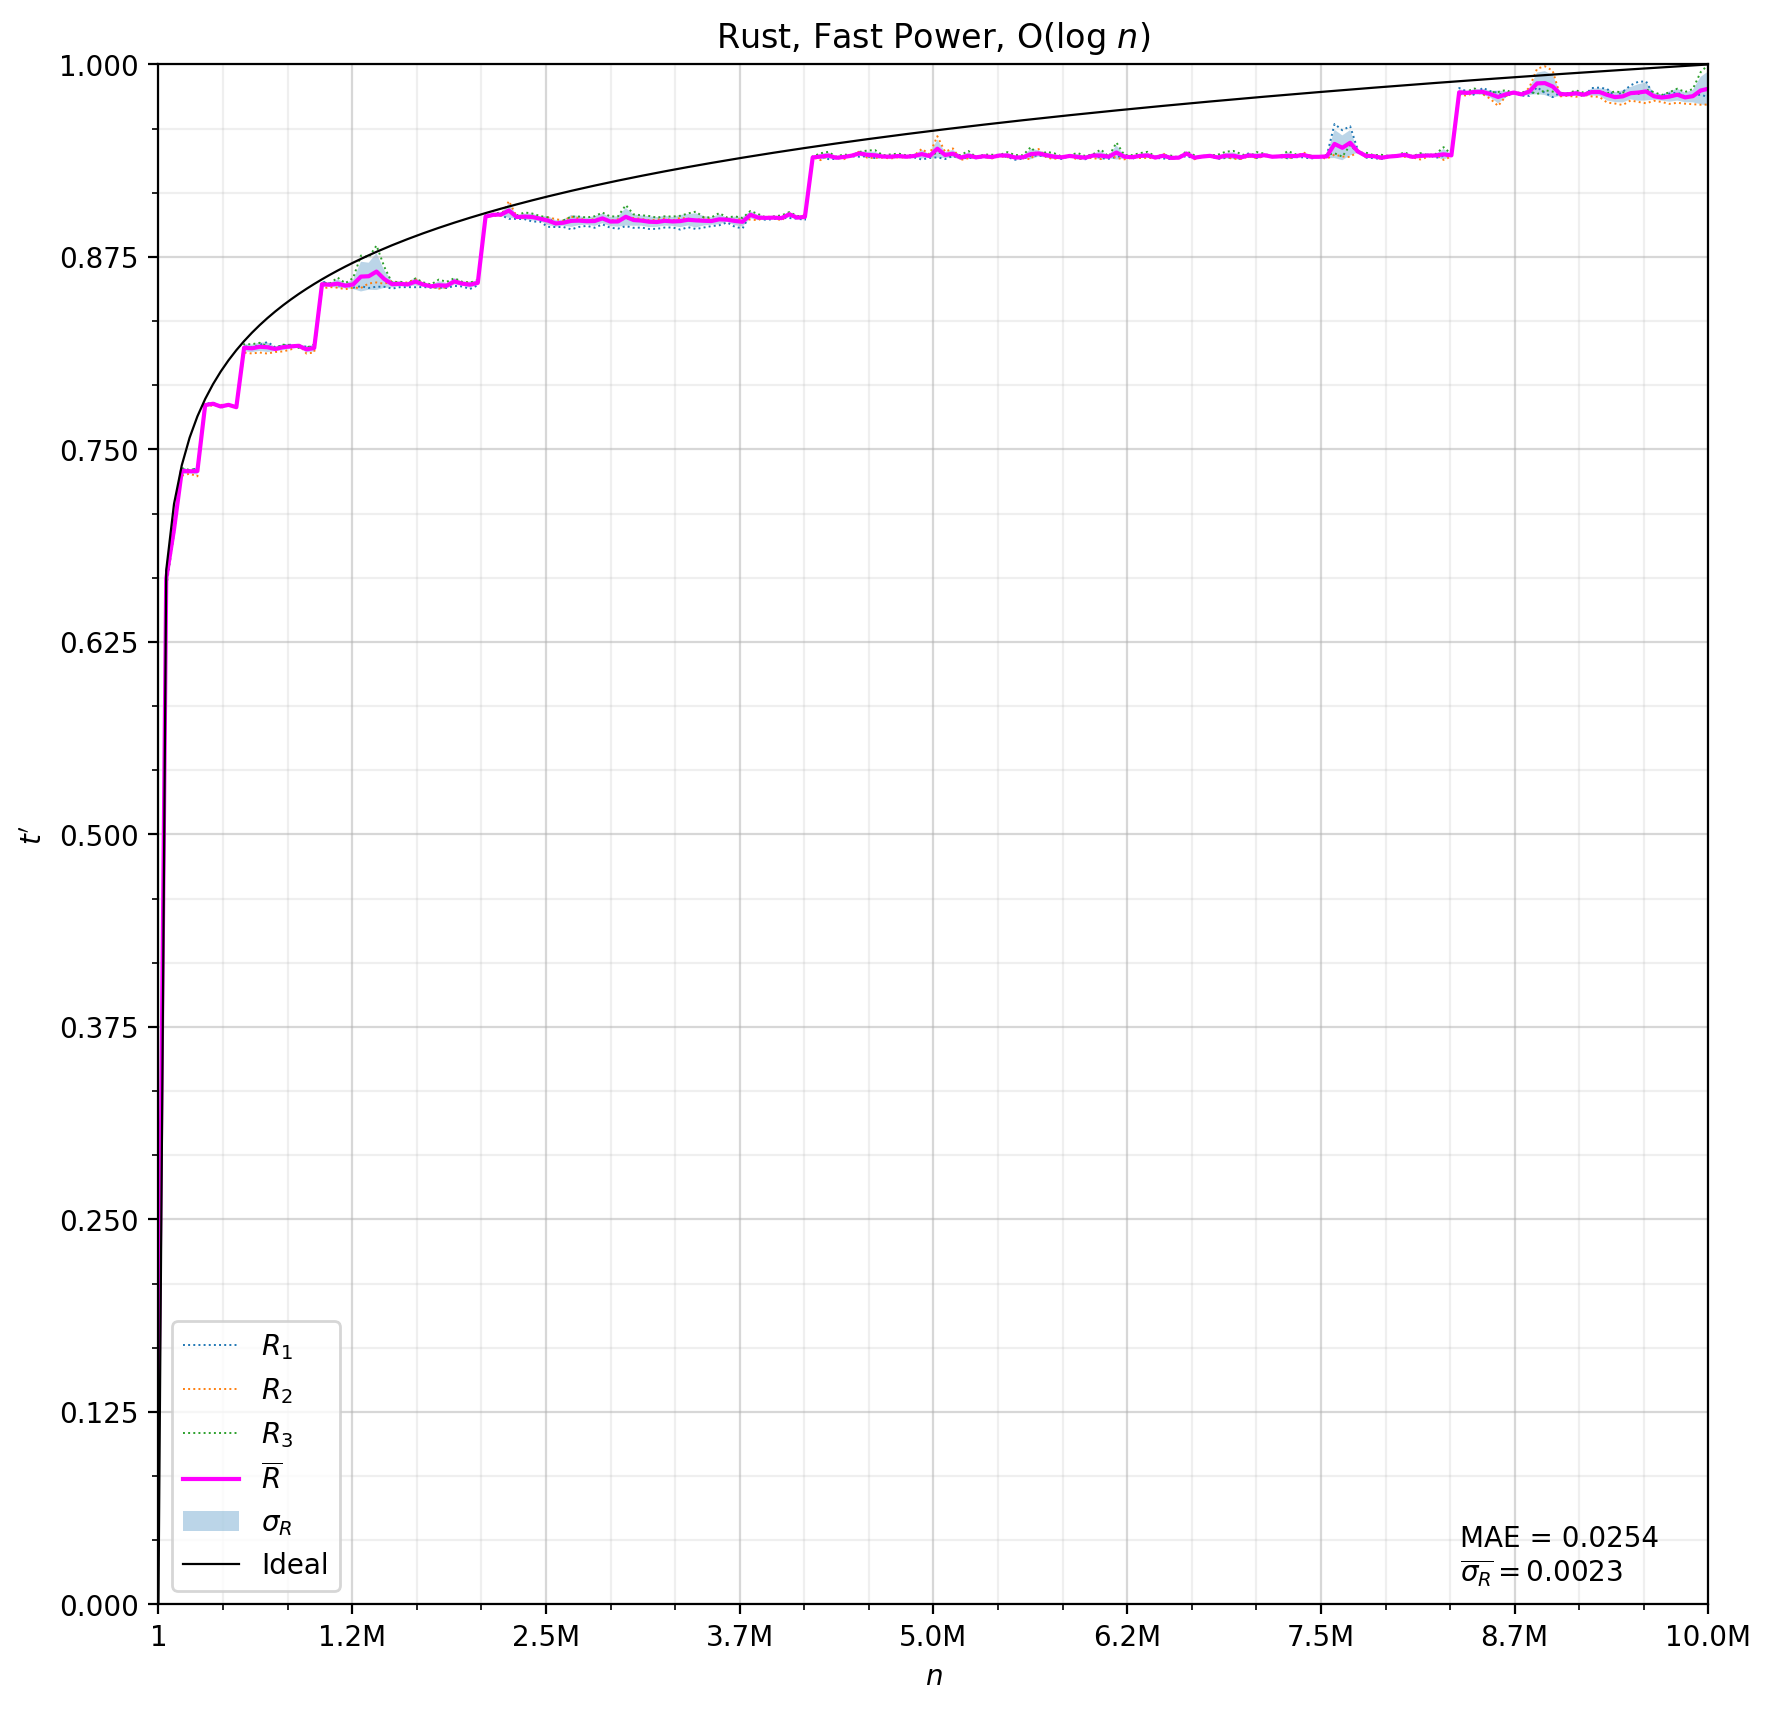

In [8]:
run_Ologn("Rust, Fast Power", *load_data("rust/gen/data", "fast_power"));

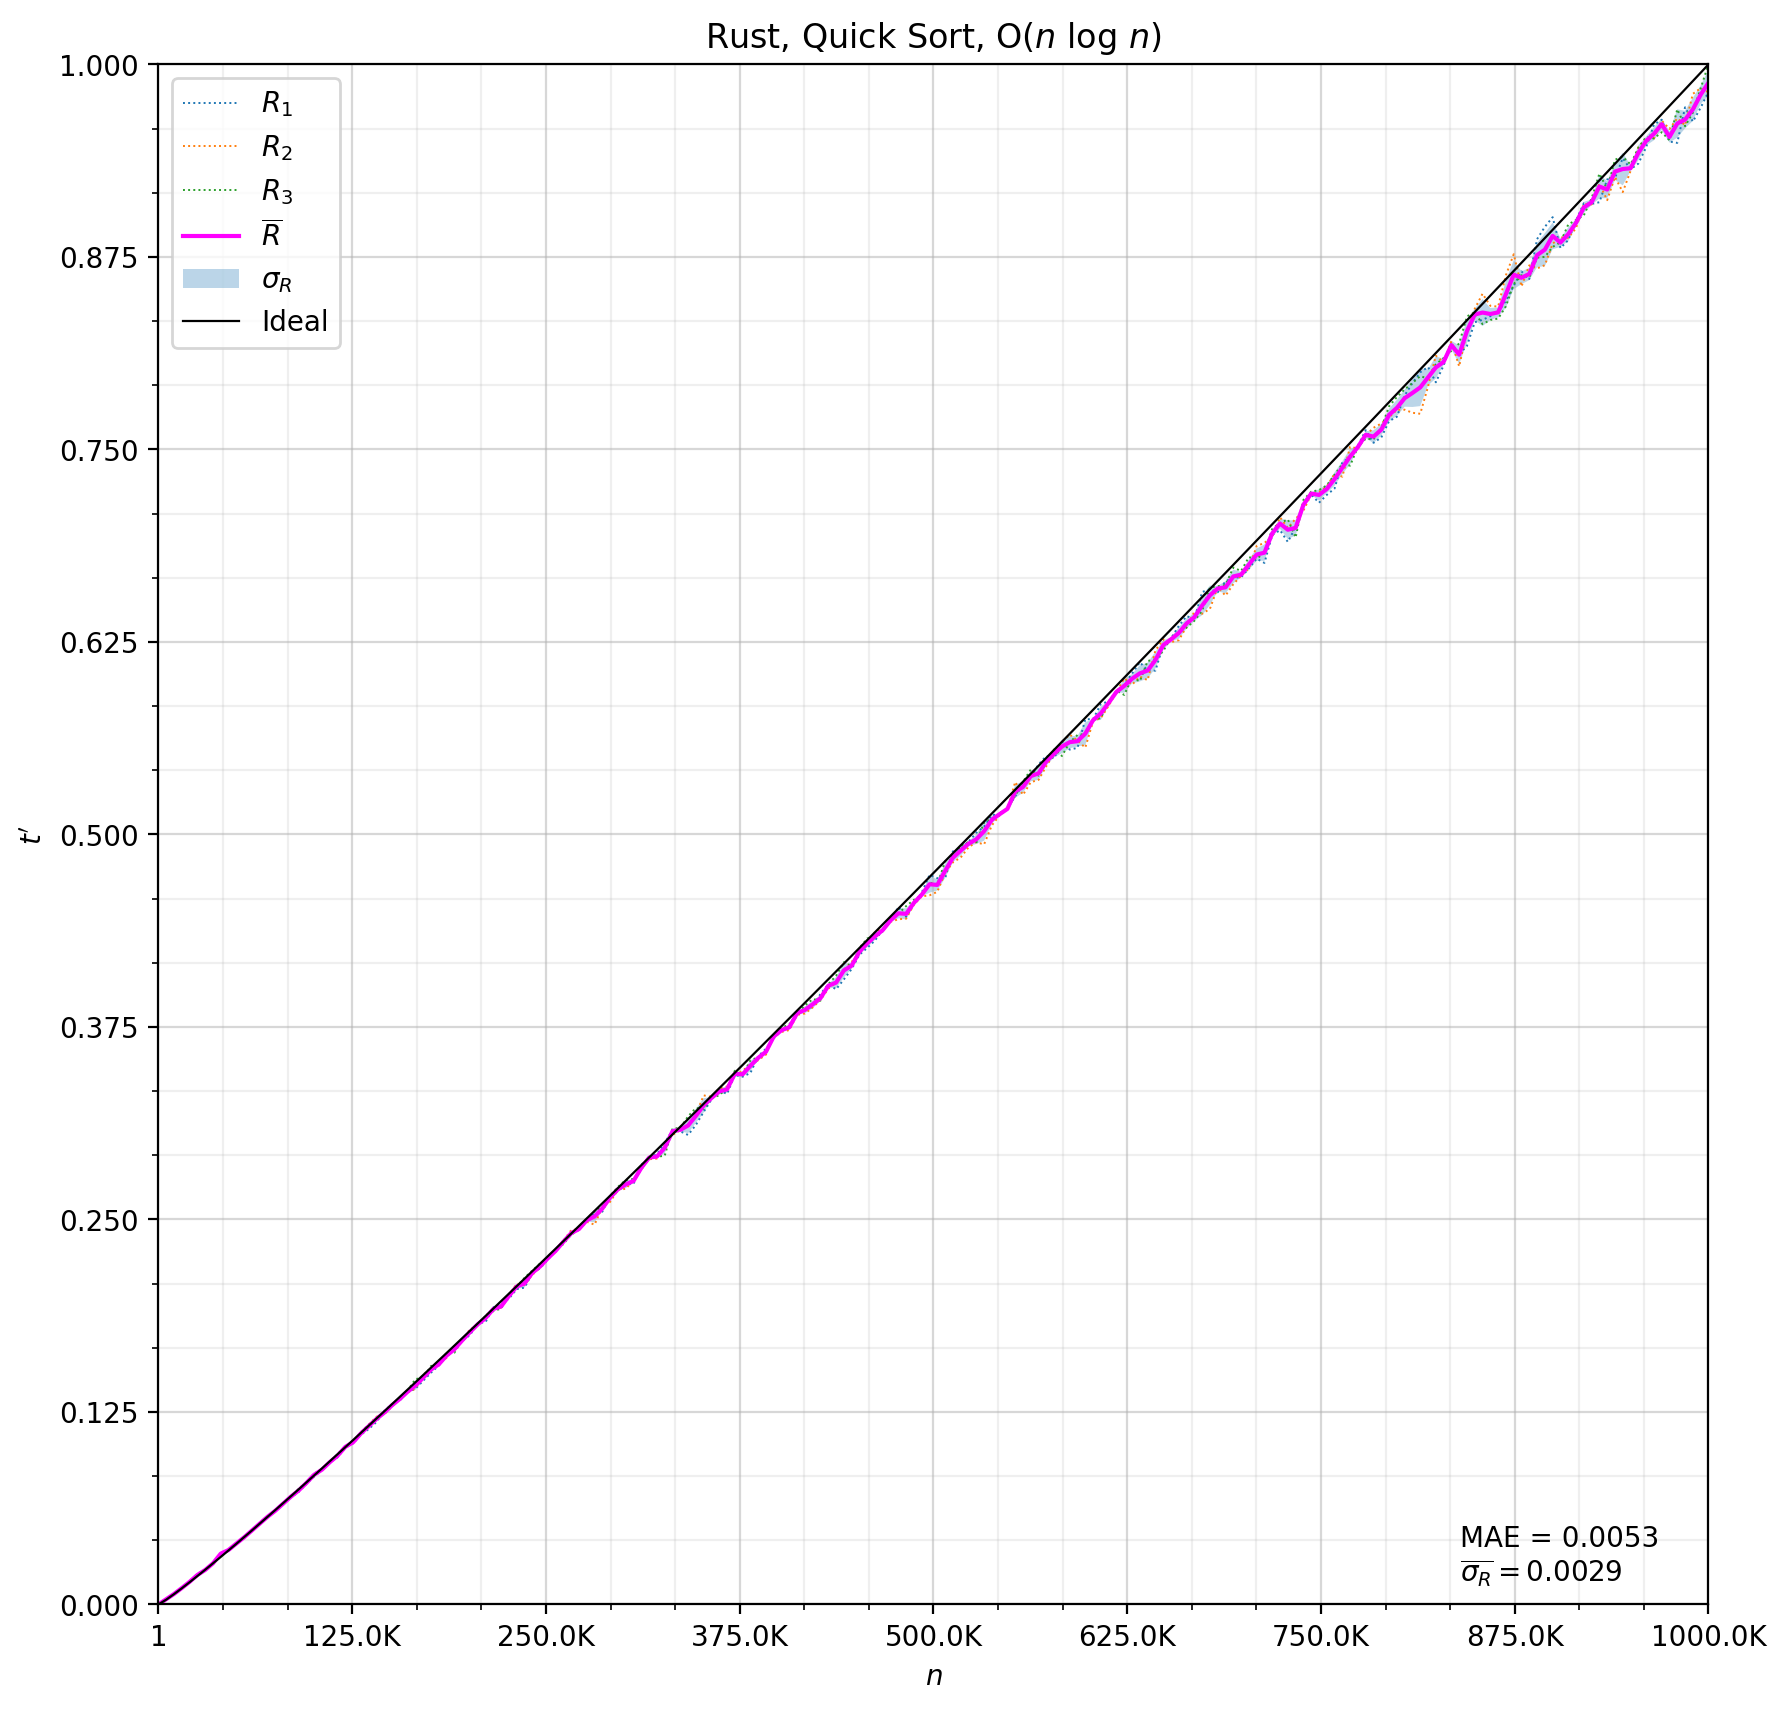

In [9]:
run_Onlogn("Rust, Quick Sort", *load_data("rust/gen/data", "qsort"));

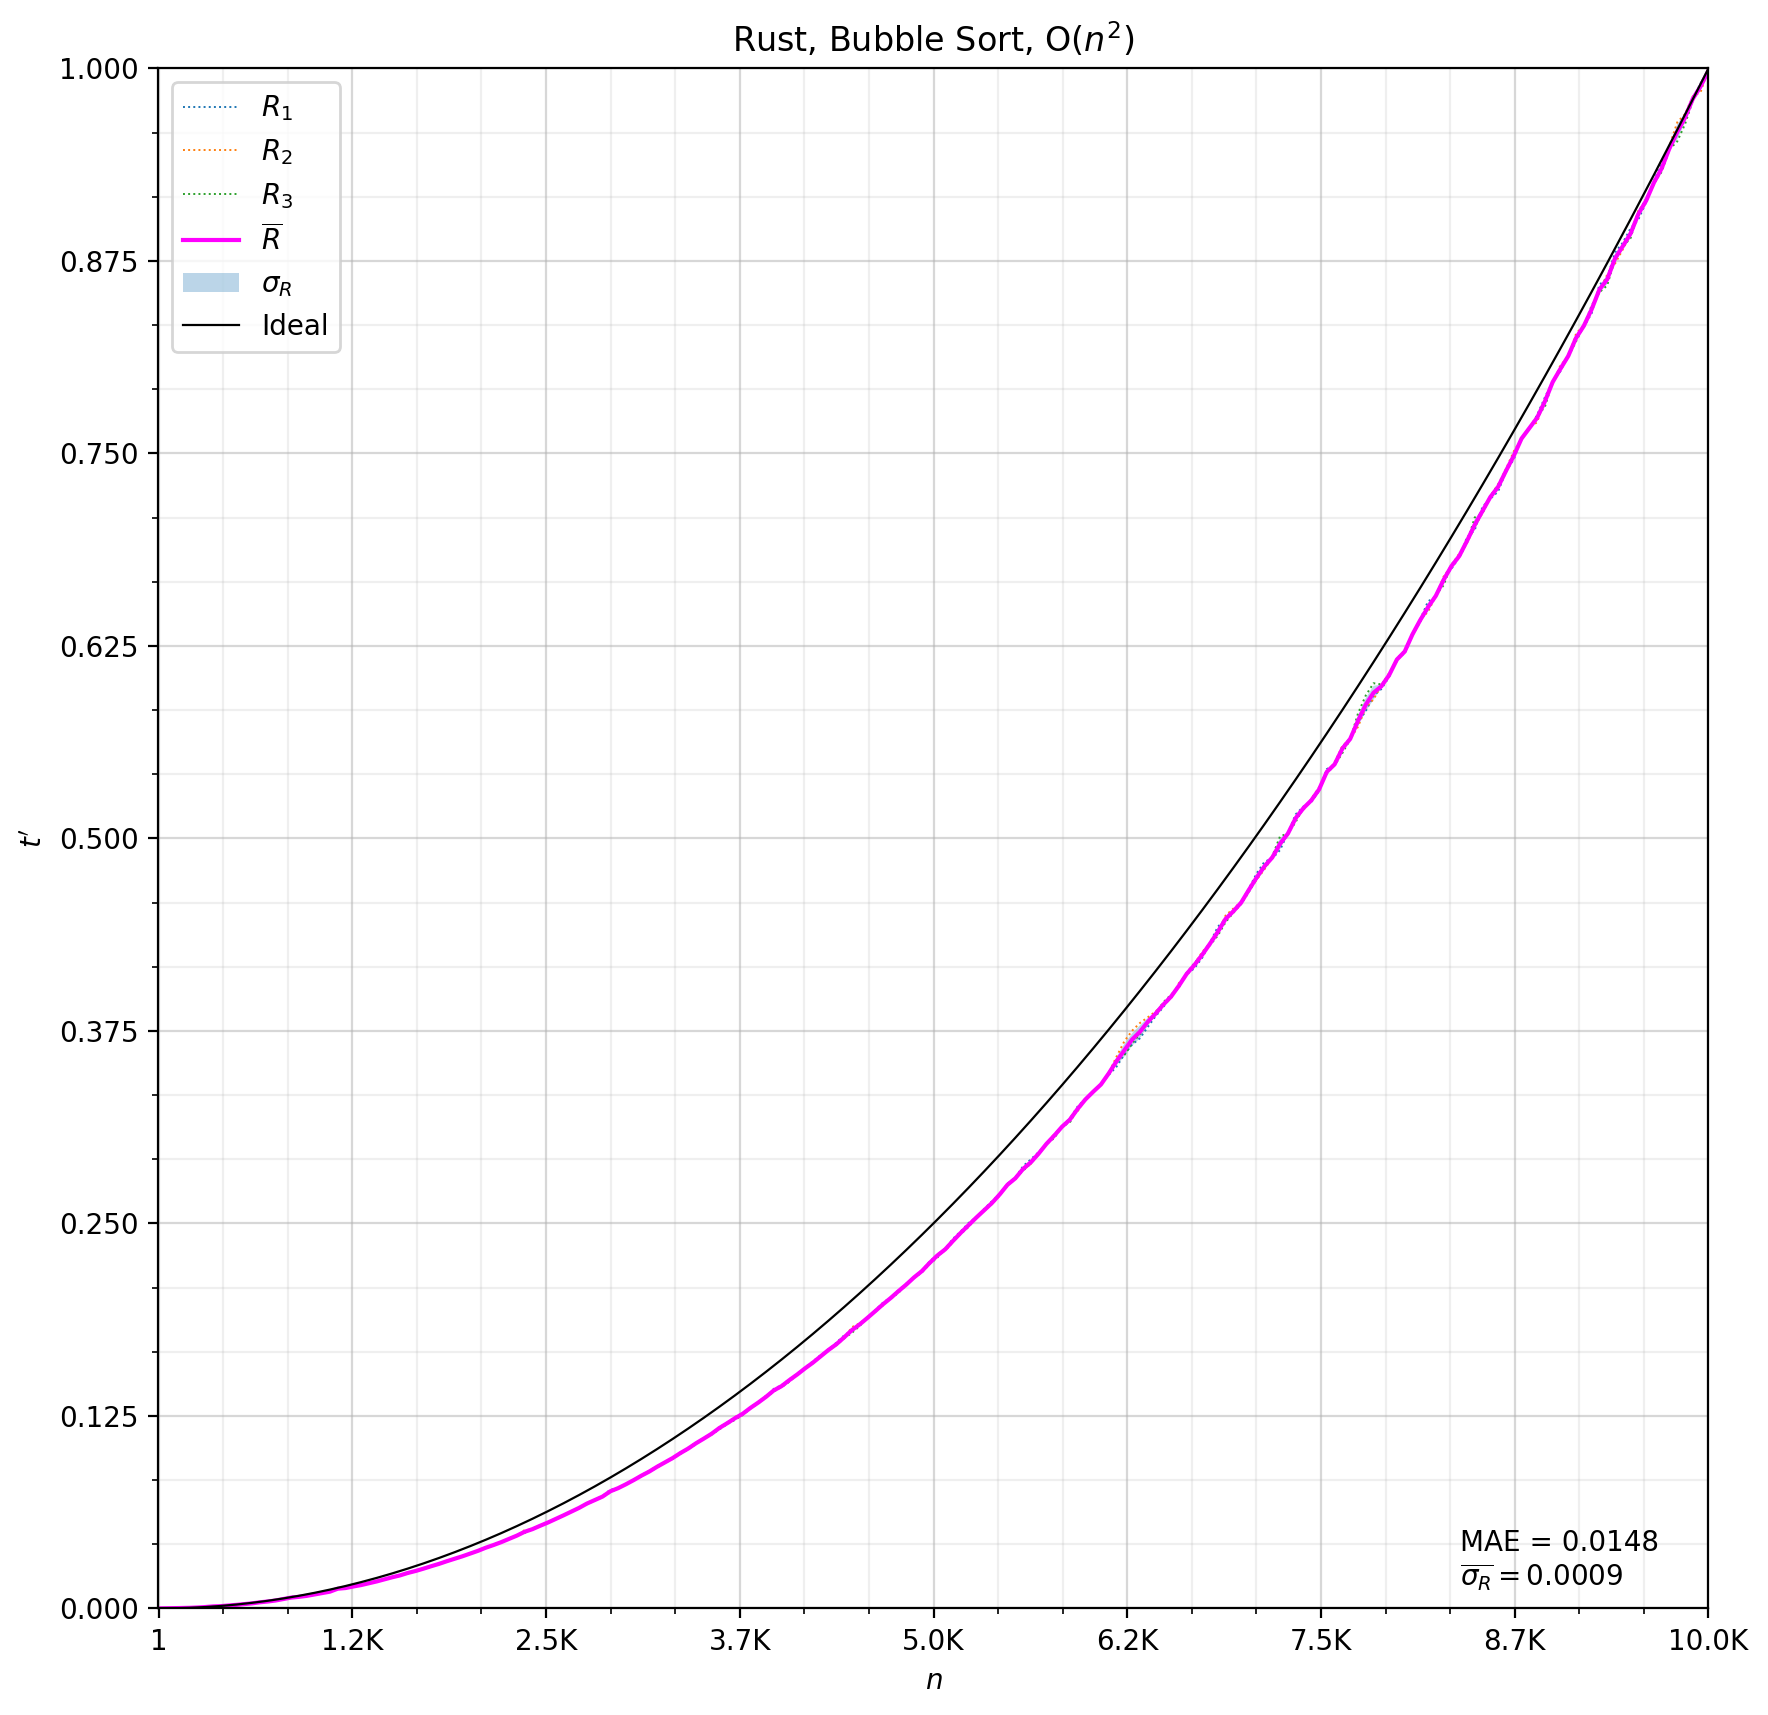

In [10]:
run_On2("Rust, Bubble Sort", *load_data("rust/gen/data", "bubble_sort"));

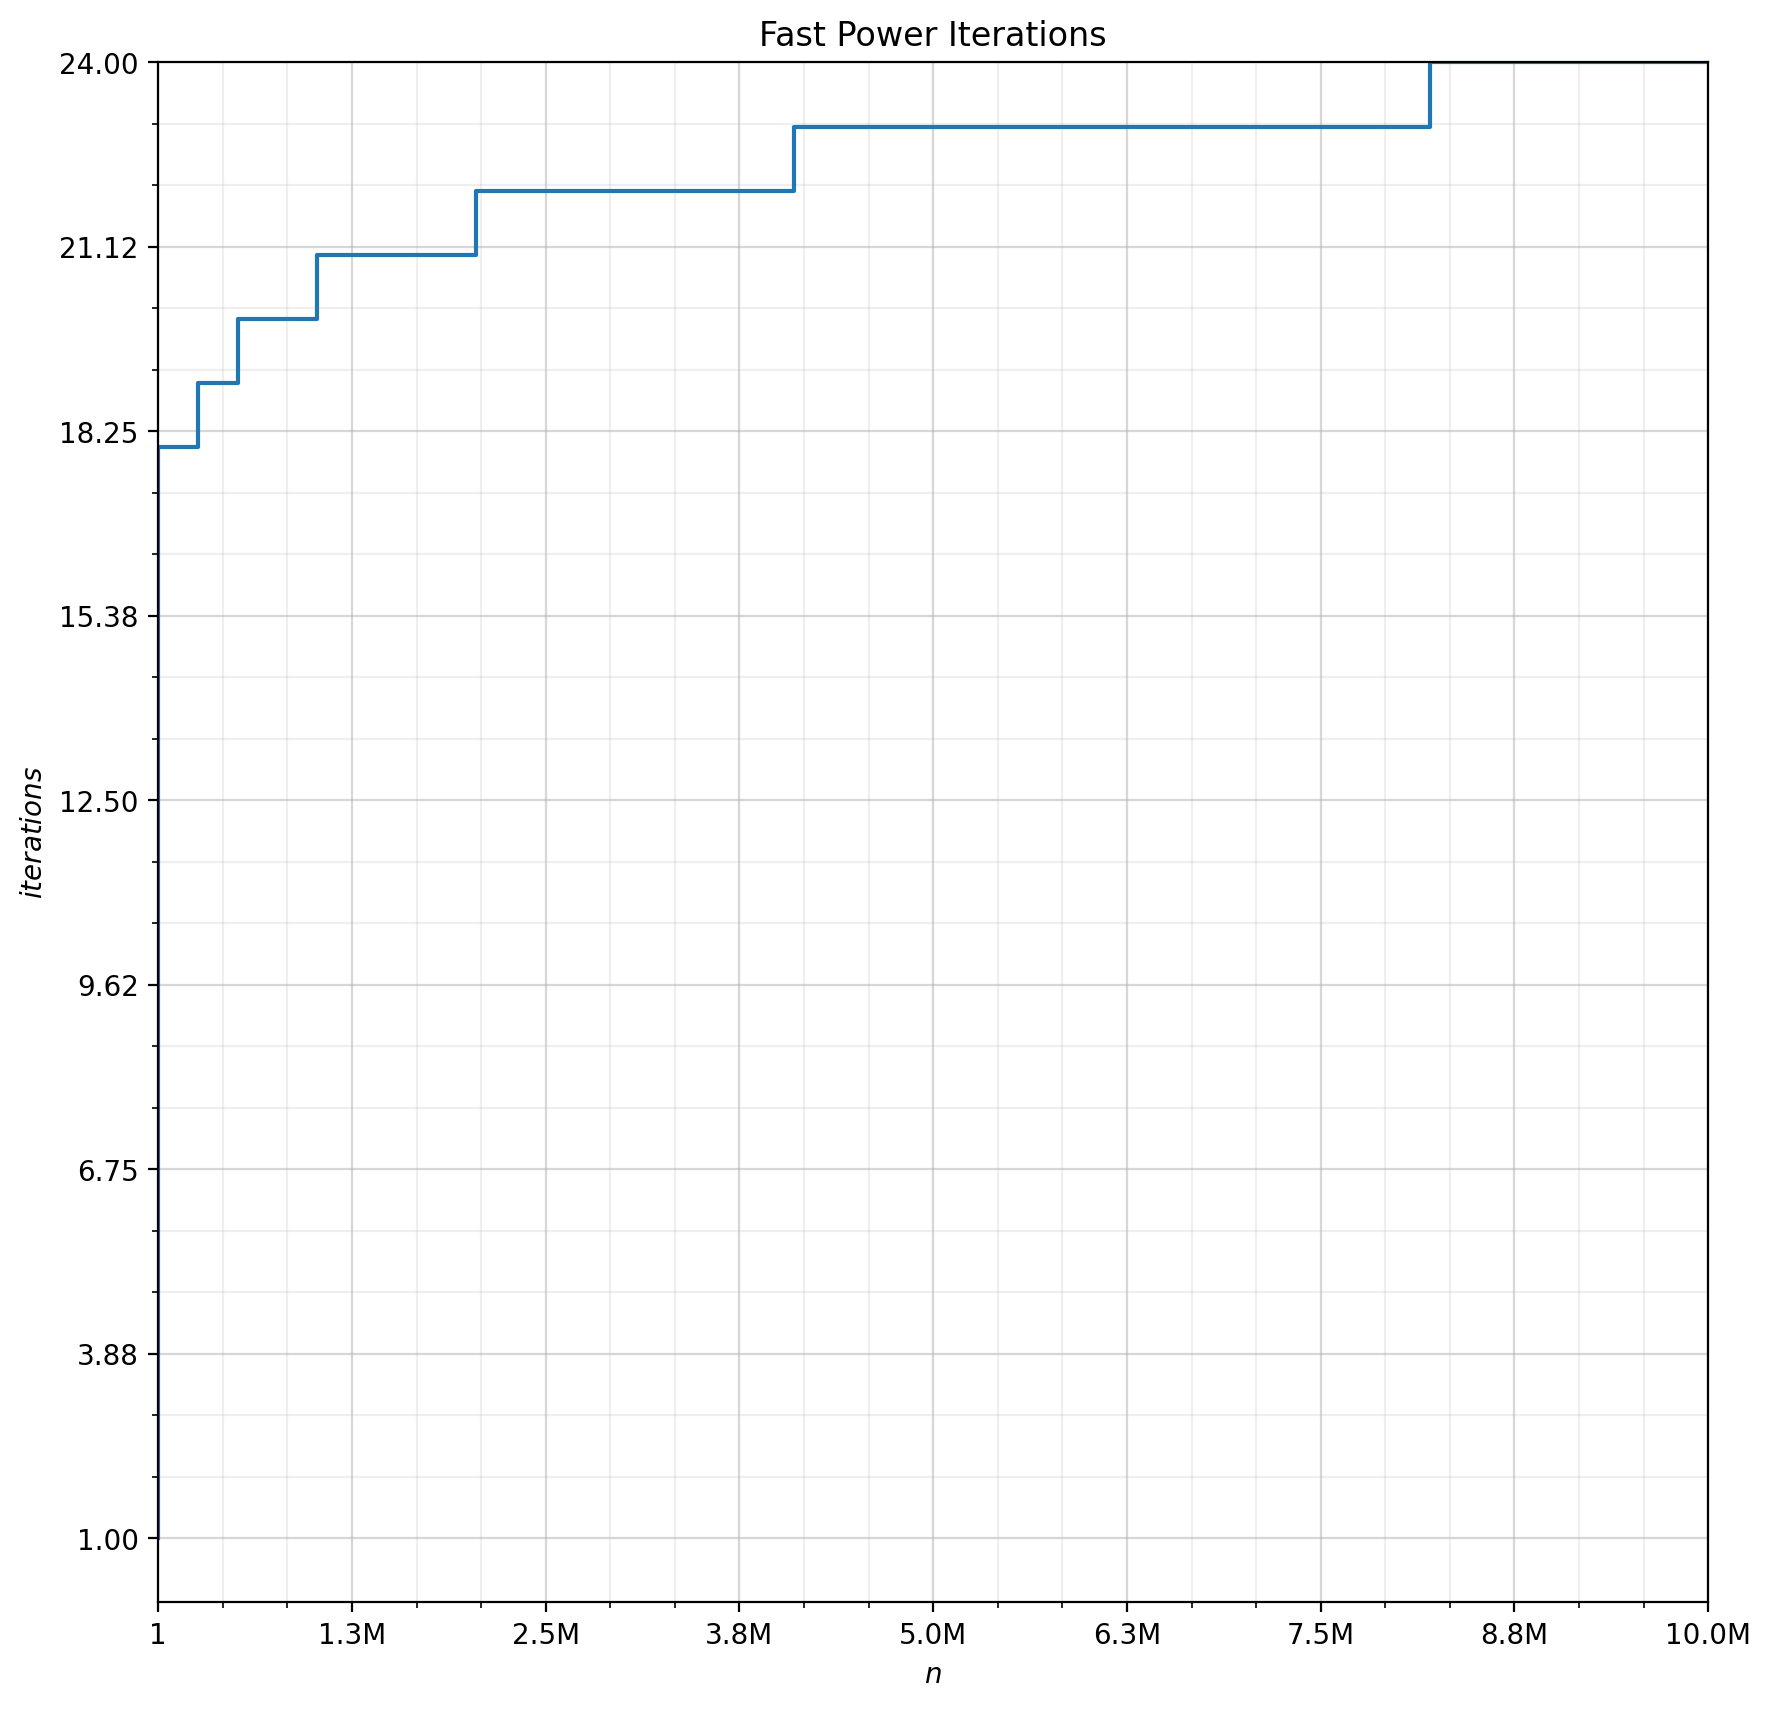

In [13]:
def gen_fast_power_iterations_data():
    def power(n, m):
        i = 0
        power, sum = n, 1

        while m > 0:
            i += 1
            if m & 1 == 1:
                sum *= power
            power = power * power
            m = m >> 1

        return i

    def run_fast_power_iterations_measure(max_n, points):
        ns = np.linspace(1, max_n, points, dtype=int)
        res = []

        for n in ns:
            pi = power(1, n)
            res.append(np.asarray([n, pi]))

        return np.asarray([np.asarray(res)])
    
    data = run_fast_power_iterations_measure(10**7, 40)
    n = data[0, :,0]
    i = data[:, :,1]
    return n, i

def run_power_iterations(n, ii):
    fig = plt.figure(figsize=(10, 10), dpi=200)

    nmean = np.mean(ii, axis=0)

    ax = fig.add_subplot(111)

    ax.set_title(f'Fast Power Iterations')
    ax.set_xlabel("$n$")
    ax.set_ylabel("$iterations$")
    config_axes(n, nmean, ax)
    ax.step(n, nmean, label=f'i')


    return fig
    
run_power_iterations(*gen_fast_power_iterations_data());